## Fine Tuning the existing model

In [ ]:
!unzip /content/drive/MyDrive/3.zip -d /content/MallDataset


Archive:  /content/drive/MyDrive/3.zip
   creating: /content/MallDataset/3/
   creating: /content/MallDataset/3/frames/
   creating: /content/MallDataset/3/frames/frames/
  inflating: /content/MallDataset/3/frames/frames/seq_000001.jpg  
  inflating: /content/MallDataset/3/frames/frames/seq_000002.jpg  
  inflating: /content/MallDataset/3/frames/frames/seq_000003.jpg  
  inflating: /content/MallDataset/3/frames/frames/seq_000004.jpg  
  inflating: /content/MallDataset/3/frames/frames/seq_000005.jpg  
  inflating: /content/MallDataset/3/frames/frames/seq_000006.jpg  
  inflating: /content/MallDataset/3/frames/frames/seq_000007.jpg  
  inflating: /content/MallDataset/3/frames/frames/seq_000008.jpg  
  inflating: /content/MallDataset/3/frames/frames/seq_000009.jpg  
  inflating: /content/MallDataset/3/frames/frames/seq_000010.jpg  
  inflating: /content/MallDataset/3/frames/frames/seq_000011.jpg  
  inflating: /content/MallDataset/3/frames/frames/seq_000012.jpg  
  inflating: /content/Mal

In [ ]:
!ls /content/MallDataset/3


frames	mall_gt.mat  perspective_roi.mat


In [ ]:
import os
import cv2
import torch
import numpy as np
import scipy.io as sio
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()

        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.frontend = nn.Sequential(*list(vgg.features)[:23])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x


In [ ]:
DATASET_PATH = "/content/MallDataset/3"  # change if needed
FRAMES_PATH = os.path.join(DATASET_PATH, "frames", "frames")

gt = sio.loadmat(os.path.join(DATASET_PATH, "mall_gt.mat"))
gt_counts = gt["count"].squeeze()

frame_files = sorted(os.listdir(FRAMES_PATH))
print("Total frames:", len(frame_files))


Total frames: 2001


In [ ]:
gt = sio.loadmat(os.path.join(DATASET_PATH, "mall_gt.mat"))
gt_counts = gt["count"].squeeze()

frame_files = sorted(os.listdir(FRAMES_PATH))

print("Frames:", len(frame_files))
print("GT entries:", len(gt_counts))
print("Min/Max count:", gt_counts.min(), gt_counts.max())


Frames: 2001
GT entries: 2000
Min/Max count: 13 53


In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset

class MallDataset(Dataset):
    def __init__(self, frames_path, gt_counts, transform=None):
        self.frames_path = frames_path
        self.gt_counts = gt_counts
        self.transform = transform

        # ✅ ONLY keep valid image files
        self.frame_files = sorted([
            f for f in os.listdir(frames_path)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ])

        assert len(self.frame_files) == len(gt_counts), \
            "Mismatch between frames and ground-truth counts"

    def __len__(self):
        return len(self.frame_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.frames_path, self.frame_files[idx])
        img = cv2.imread(img_path)

        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (1024, 768))
        img = img / 255.0
        img = torch.tensor(img).permute(2, 0, 1).float()

        gt = torch.tensor(self.gt_counts[idx]).float()

        return img, gt


In [ ]:
dataset = MallDataset(
    frames_path=FRAMES_PATH,
    gt_counts=gt_counts
)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


In [ ]:
ckpt = torch.load("/content/drive/MyDrive/CSRNet_Training/finetuned_epoch_29.pth",
                  map_location=device)
print(type(ckpt))


<class 'dict'>


In [ ]:
ckpt = torch.load(
    "/content/drive/MyDrive/CSRNet_Training/finetuned_epoch_29.pth",
    map_location=device
)

print(ckpt.keys())


dict_keys(['epoch', 'model', 'optimizer'])


In [ ]:
model = CSRNet().to(device)
model.load_state_dict(ckpt["model"])
model.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)  # Fine-tuning LR


In [ ]:
import os
from tqdm import tqdm

EPOCHS = 5
SAVE_DIR = "/content/drive/MyDrive/CSRNet_Training/mall_checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

for epoch in range(EPOCHS):
    total_loss = 0.0
    model.train()

    for imgs, gt in tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs = imgs.to(device)
        gt = gt.to(device)

        optimizer.zero_grad()

        density = model(imgs)
        pred_count = density.sum(dim=[1, 2, 3])

        loss = criterion(pred_count, gt)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)

    print(f"📘 Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

    # 🔹 SAVE CHECKPOINT
    ckpt_path = os.path.join(
        SAVE_DIR, f"csrnet_mall_epoch_{epoch+1}.pth"
    )

    torch.save({
        "epoch": epoch + 1,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "loss": avg_loss
    }, ckpt_path)

    print(f"💾 Saved checkpoint: {ckpt_path}")


Epoch 1/5: 100%|██████████| 2000/2000 [12:58<00:00,  2.57it/s]


📘 Epoch 1 | Avg Loss: 15.7709
💾 Saved checkpoint: /content/drive/MyDrive/CSRNet_Training/mall_checkpoints/csrnet_mall_epoch_1.pth


Epoch 2/5: 100%|██████████| 2000/2000 [12:58<00:00,  2.57it/s]


📘 Epoch 2 | Avg Loss: 11.8663
💾 Saved checkpoint: /content/drive/MyDrive/CSRNet_Training/mall_checkpoints/csrnet_mall_epoch_2.pth


Epoch 3/5: 100%|██████████| 2000/2000 [12:58<00:00,  2.57it/s]


📘 Epoch 3 | Avg Loss: 10.6827
💾 Saved checkpoint: /content/drive/MyDrive/CSRNet_Training/mall_checkpoints/csrnet_mall_epoch_3.pth


Epoch 4/5: 100%|██████████| 2000/2000 [12:58<00:00,  2.57it/s]


📘 Epoch 4 | Avg Loss: 9.8706
💾 Saved checkpoint: /content/drive/MyDrive/CSRNet_Training/mall_checkpoints/csrnet_mall_epoch_4.pth


Epoch 5/5: 100%|██████████| 2000/2000 [12:59<00:00,  2.57it/s]


📘 Epoch 5 | Avg Loss: 8.9345
💾 Saved checkpoint: /content/drive/MyDrive/CSRNet_Training/mall_checkpoints/csrnet_mall_epoch_5.pth


In [ ]:
FINAL_MODEL_PATH = "/content/drive/MyDrive/CSRNet_Training/csrnet_mall_finetuned_final.pth"

torch.save(model.state_dict(), FINAL_MODEL_PATH)

print("✅ Final fine-tuned CSRNet model saved")
print("📍 Path:", FINAL_MODEL_PATH)


✅ Final fine-tuned CSRNet model saved
📍 Path: /content/drive/MyDrive/CSRNet_Training/csrnet_mall_finetuned_final.pth


In [ ]:
model.eval()
preds = []

with torch.no_grad():
    for imgs, _ in tqdm(loader, desc="Evaluating"):
        imgs = imgs.to(device)

        density = model(imgs)
        counts = density.sum(dim=[1, 2, 3]).cpu().numpy()
        preds.extend(counts)

preds = np.array(preds[:len(gt_counts)])

mae = np.mean(np.abs(preds - gt_counts))
print("📊 MAE:", mae)


Evaluating: 100%|██████████| 2000/2000 [04:24<00:00,  7.57it/s]

📊 MAE: 7.5871577


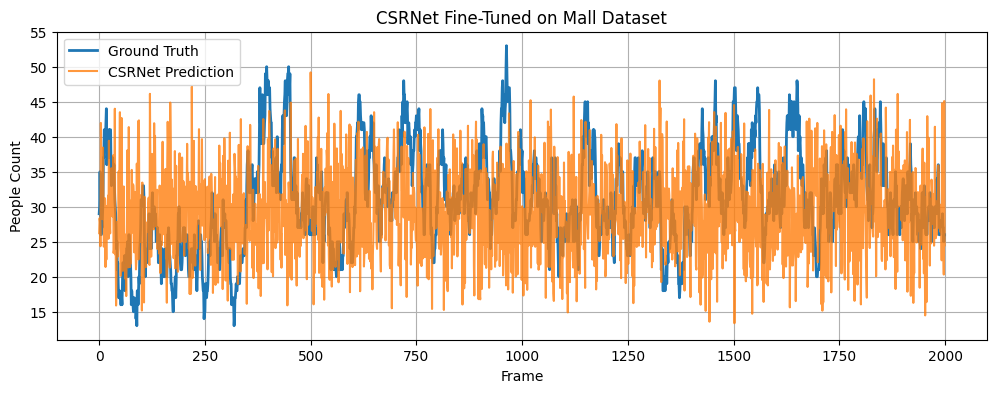

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(gt_counts, label="Ground Truth", linewidth=2)
plt.plot(preds, label="CSRNet Prediction", alpha=0.8)
plt.legend()
plt.xlabel("Frame")
plt.ylabel("People Count")
plt.title("CSRNet Fine-Tuned on Mall Dataset")
plt.grid(True)
plt.show()


In [ ]:
from google.colab import files

files.download("/content/drive/MyDrive/CSRNet_Training/mall_checkpoints/csrnet_mall_epoch_5.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Testing Model on Multiple Videos

In [14]:
!unzip /content/drive/MyDrive/test.zip -d /content/

Archive:  /content/drive/MyDrive/test.zip
   creating: /content/test/
  inflating: /content/test/test1.mp4  
  inflating: /content/test/test10.mp4  
  inflating: /content/test/test2.mp4  
  inflating: /content/test/test3.mp4  
  inflating: /content/test/test4.mp4  
  inflating: /content/test/test5.mp4  
  inflating: /content/test/test6.mp4  
  inflating: /content/test/test7.mp4  
  inflating: /content/test/test8.mp4  
  inflating: /content/test/test9.mp4  


In [2]:
import cv2
import torch
import time
import numpy as np
from PIL import Image
from IPython.display import display, clear_output
import torch.nn as nn
import torchvision.models as models
import os


In [3]:
class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()

        vgg = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features)[:23])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x



In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

csrnet = CSRNet().to(device)
ckpt = torch.load("/content/drive/MyDrive/CSRNet_Training/mall_checkpoints/csrnet_mall_epoch_5.pth", map_location=device)
csrnet.load_state_dict(ckpt["model"])
csrnet.eval()

print("✅ CSRNet loaded on:", device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ CSRNet loaded on: cuda


In [5]:
def preprocess_frame(frame):
    frame_resized = cv2.resize(frame, (1024, 768))
    frame_resized = frame_resized / 255.0
    frame_resized = frame_resized.transpose(2, 0, 1)
    tensor = torch.tensor(frame_resized, dtype=torch.float32).unsqueeze(0).to(device)
    return tensor


In [6]:
def csrnet_count(frame):
    inp = preprocess_frame(frame)

    with torch.no_grad():
        density_map = csrnet(inp).cpu().numpy()[0, 0]

    count = density_map.sum()

    # Normalize density map for visualization
    heatmap = density_map / density_map.max()
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (frame.shape[1], frame.shape[0]))

    overlay = cv2.addWeighted(frame, 0.6, heatmap, 0.4, 0)

    alert = "SAFE"
    color = (0, 255, 0)
    if count > 100:
        alert = "⚠️ CROWD ALERT"
        color = (0, 0, 255)

    cv2.putText(
        overlay,
        f"Count: {count:.1f} | {alert}",
        (20, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.2,
        color,
        3
    )

    return overlay, count, alert


In [7]:
INPUT_VIDEO_DIR = "/content/test/"
OUTPUT_VIDEO_DIR = "/content/drive/MyDrive/CSRNet_Training/csrnet_out"

os.makedirs(OUTPUT_VIDEO_DIR, exist_ok=True)
print("Folder created:", OUTPUT_VIDEO_DIR)


Folder created: /content/drive/MyDrive/CSRNet_Training/csrnet_out


In [8]:
videos = [v for v in os.listdir(INPUT_VIDEO_DIR) if v.endswith(".mp4")]
print("🎥 Videos found:", videos)

🎥 Videos found: ['test3.mp4', 'test2.mp4', 'test6.mp4', 'test1.mp4', 'test7.mp4', 'test5.mp4', 'test8.mp4', 'test9.mp4', 'test10.mp4', 'test4.mp4']


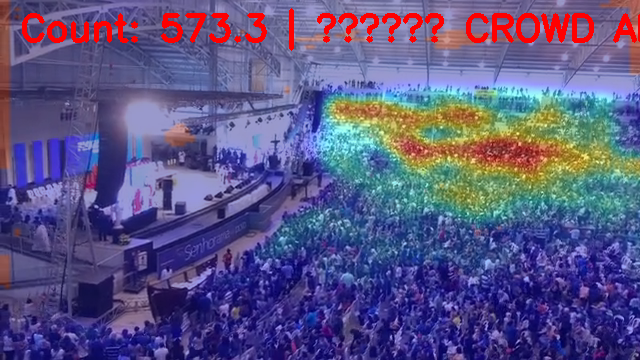

🎬 Video: test4.mp4
🎞 Frame: 1135/1136
📊 Progress: 99.9%
👥 Count: 573.3 | ⚠️ CROWD ALERT
⏳ Elapsed: 179.2s
⏱ ETA: 0.2s
✅ Finished: test4.mp4
📁 Saved as: /content/drive/MyDrive/CSRNet_Training/csrnet_out/test4_csrnet_out.mp4

🎉 All videos processed successfully!


In [9]:
for video_name in videos:

    VIDEO_PATH = os.path.join(INPUT_VIDEO_DIR, video_name)
    OUTPUT_PATH = os.path.join(
        OUTPUT_VIDEO_DIR,
        video_name.replace(".mp4", "_csrnet_out.mp4")
    )

    cap = cv2.VideoCapture(VIDEO_PATH)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (w, h))

    frame_id = 0
    start_time = time.time()

    print(f"\n🚀 Processing video: {video_name}")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        processed, count, alert = csrnet_count(frame)
        out.write(processed)

        frame_id += 1

        if frame_id % 5 == 0:
            elapsed = time.time() - start_time
            avg = elapsed / frame_id
            remaining = (total_frames - frame_id) * avg
            progress = (frame_id / total_frames) * 100

            rgb = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
            clear_output(wait=True)
            display(Image.fromarray(rgb))

            print(f"🎬 Video: {video_name}")
            print(f"🎞 Frame: {frame_id}/{total_frames}")
            print(f"📊 Progress: {progress:.1f}%")
            print(f"👥 Count: {count:.1f} | {alert}")
            print(f"⏳ Elapsed: {elapsed:.1f}s")
            print(f"⏱ ETA: {remaining:.1f}s")

    cap.release()
    out.release()

    print(f"✅ Finished: {video_name}")
    print(f"📁 Saved as: {OUTPUT_PATH}")

print("\n🎉 All videos processed successfully!")

In [10]:
import shutil

folder_path = "/content/drive/MyDrive/CSRNet_Training/csrnet_out"
zip_path = "/content/csrnet_out.zip"

shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_path)

print("ZIP created:", zip_path)


ZIP created: /content/csrnet_out.zip


In [13]:
from google.colab import files
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>